<b>1: Initialize cluster centers Ck = [lk, ak, bk, xk, yk]^T by sampling pixels at regular grid steps S.<br>
2: Perturb cluster centers in an n × n neighborhood, to the lowest gradient position.<br>
3: repeat<br>
4: &emsp; for each cluster center Ck do<br>
5: &emsp; &emsp; Assign the best matching pixels from a 2S × 2S square neighborhood around the cluster center according to the distance measure <br>
6: &emsp; &emsp; end for<br>
7: &emsp; Compute new cluster centers and residual error E {L1 distance between previous centers and recomputed centers}<br>
8: &emsp; until E ≤ threshold<br>
9: Enforce connectivity</b>

In [ ]:
import math
import cv2
from matplotlib import pyplot as plt
import numpy as np

(63, 100, 3)
63
100
18900


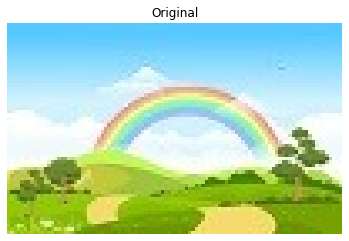

In [ ]:
img = cv2.imread('rainb.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #view the actual image we need to convert the rendering to Red Green Blue (RGB)

plt.axis("off")
plt.title('Original')
plt.imshow(img)

shape = img.shape
rows,columns = shape[0],shape[1]

print(shape)
print(rows)
print(columns)
total_number_of_elements= img.size
print(total_number_of_elements)

In [ ]:
N = rows*columns
m = 10
K = 100
S = math.sqrt(N/K)

In [ ]:
R = np.zeros([rows,columns])
G = np.zeros([rows,columns])
B = np.zeros([rows,columns])
print(img[1,1])
for i in range(rows):
    for j in range(columns):
        r,g,b = (img[i,j])
        R[i][j] = r/255
        G[i][j] = g/255
        B[i][j] = b/255
#print(R)
#print(G)
#print(B)
RGB = np.zeros([R.shape[0], R.shape[1], 3])
RGB[:,:,0] = R
RGB[:,:,1] = G
RGB[:,:,2] = B
#print(RGB)

[ 86 199 255]


In [ ]:
# compute initial clusters
# the 5 positions are: 1-R, 2-G, 3-B, 4-x, 5-y
# in the original algorithm 1-L, 2-a, 3-b (the CIE-L*a*b color space)
C = np.zeros((K, 5))
#print(C)
k = 0

# define center of K clusters (x, y)
k = 0
for y in range(math.floor(S / 2), rows, math.floor(rows / math.sqrt(K))): #(5,168,,8)
    for x in range(math.floor(S / 2), columns, math.floor(columns / math.sqrt(K))): #(5,300,15)
        if k >= K:
            continue
        C[k, 0] = R[y, x]
        C[k, 1] = G[y, x]
        C[k, 2] = B[y, x]
        C[k, 3] = x
        C[k, 4] = y
        #print(x,y)
        #print(C[k,3],C[k,4])
        #print()
        k = k + 1

In [ ]:
# compute superpixels matrix
superpixels = np.zeros((N, 5))
i = 0
for y in range(0, rows):
    for x in range(0, columns):
        superpixels[i, 0] = R[y, x]
        superpixels[i, 1] = G[y, x]
        superpixels[i, 2] = B[y, x]
        superpixels[i, 3] = x
        superpixels[i, 4] = y
        i = i + 1

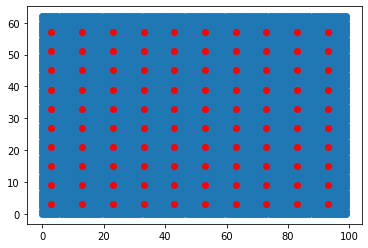

In [ ]:
plt.scatter(superpixels[:,3],superpixels[:,4],marker='o' )
colmap = {0: 'r', 1: 'g', 2: 'y', 3:'b'}

plt.scatter(C[:,3], C[:,4], color=colmap[0])
plt.show()

In [ ]:
def distance_slic(pixel_k, pixel_i, m, S):
    d_rgb = math.sqrt( (pixel_k[0]-pixel_i[0])**2 + (pixel_k[1]-pixel_i[1])**2 + (pixel_k[2]-pixel_i[2])**2 )
    d_xy = math.sqrt( (pixel_k[3]-pixel_i[3])**2 + (pixel_k[4]-pixel_i[4])**2 )
    final_distance = d_rgb + m * d_xy / S
    return final_distance

In [ ]:
# run SLIC k-means
SLIC = np.ones_like(R)
error_threshold = 6
residual_error = error_threshold + 1
i = 0
max_i = 20
while residual_error>error_threshold:
    SLIC = np.ones_like(R)
    # define no data as K + 100 value
    SLIC *= (K * 100)

    print ("iteration", i)
    residual_error = 0.0
    #assign the best matching pixels from a 2S × 2S square neighborhood around the cluster center according to the distance measure
    for k in range(K):
        center_x = C[k, 3]
        center_y = C[k, 4]
        
        left_y = max(0, math.floor(center_y - S))
        right_y = min(rows, math.floor(center_y + S))
        left_x = max(0, math.floor(center_x - S))
        right_x = min(columns, math.floor(center_x + S))
        
        for y in range(left_y, right_y):
            for x in range(left_x, right_x):
                distances_to_clusters = np.zeros(K)
                for k1 in range(K):
                    pixel_k = np.array([C[k1, 0], C[k1, 1], C[k1, 2], C[k1, 3], C[k1, 4]])
                    pixel_i = np.array([R[y, x], G[y, x], B[y, x], x, y])
                    distances_to_clusters[k1] = distance_slic(pixel_k, pixel_i, m, S)
                    
                if np.argmin(distances_to_clusters) == k:
                    SLIC[y, x] = k
    # compute new cluster centers and residual error E
    for k in range(K):
        center_R = C[k, 0]
        center_G = C[k, 1]
        center_B = C[k, 2]
        center_x = C[k, 3]
        center_y = C[k, 4]
        
        new_center = np.zeros(5)
        total_in_k = 0
        
        for j in range(N):
            x = int(superpixels[j, 3])
            y = int(superpixels[j, 4])
            
            if SLIC[y, x] == k:
                new_center = new_center + superpixels[j, :]
                total_in_k = total_in_k + 1
                
        if total_in_k > 0:
            new_center = new_center / total_in_k
            error = C[k, :] - new_center
            residual_error = residual_error + math.sqrt(error.dot(error.transpose()))
            C[k, :] = new_center

    print ("residual error is", residual_error, "at iteration", i)
    i = i + 1
    
    if i > max_i:
        break;
    

# make final segmentation set SLIC matrix
SLIC = np.ones_like(R)
# define no data as K + 100 value
SLIC *= (K * 100)
# iterate again
for j in range(N):
    x = int(superpixels[j, 3])
    y = int(superpixels[j, 4])
    distances_to_clusters = np.zeros(K)
    for k in range(K):
        pixel_k = np.array([C[k, 0], C[k, 1], C[k, 2], C[k, 3], C[k, 4]])
        pixel_i = superpixels[j, :]
        distances_to_clusters[k] = distance_slic(pixel_k, pixel_i, m, S)
    SLIC[y, x] = np.argmin(distances_to_clusters)

iteration 0
residual error is 53.41632415662397 at iteration 0
iteration 1
residual error is 28.17338183033898 at iteration 1
iteration 2
residual error is 15.05105185090345 at iteration 2
iteration 3
residual error is 11.941956454068457 at iteration 3
iteration 4
residual error is 11.989741581186335 at iteration 4
iteration 5
residual error is 10.488478092033725 at iteration 5
iteration 6
residual error is 10.394010304565311 at iteration 6
iteration 7
residual error is 11.537025254601133 at iteration 7
iteration 8
residual error is 10.205619275708814 at iteration 8
iteration 9
residual error is 11.000649756861748 at iteration 9
iteration 10
residual error is 10.434139354526629 at iteration 10
iteration 11
residual error is 9.33186817775713 at iteration 11
iteration 12
residual error is 8.473889119066259 at iteration 12
iteration 13
residual error is 9.61730129669031 at iteration 13
iteration 14
residual error is 9.39815284936236 at iteration 14
iteration 15
residual error is 9.3365528

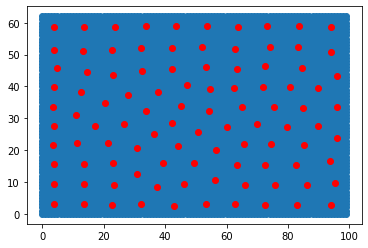

In [ ]:
plt.scatter(superpixels[:,3],superpixels[:,4] )
colmap = {0: 'r', 1: 'g', 2: 'y', 3:'b'}

plt.scatter(C[:,3], C[:,4], color=colmap[0])
plt.show()

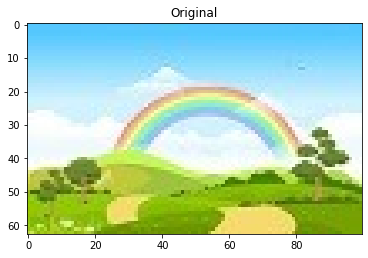

In [ ]:
plt.title('Original')
plt.imshow(img)
plt.show()

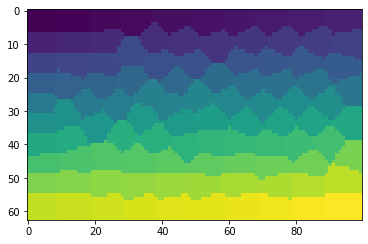

In [ ]:
plt.imshow(SLIC)

In [ ]:
for i in range(63):
    for j in range(100):
        SLIC[i][j] = int(SLIC[i][j])

In [ ]:
print(segments_slic)
segments_slic.shape

[[ 0  0  0 ... 12 12 12]
 [ 0  0  0 ... 12 12 12]
 [ 0  0  0 ... 12 12 12]
 ...
 [81 81 81 ... 91 91 91]
 [81 81 81 ... 91 91 91]
 [81 81 81 ... 91 91 91]]


(63, 100)